In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from chemprop.cli import train, predict
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Loading the dataset.

In [3]:
df = pd.read_csv('../dataset.csv')

Filtering for the "Caenorhabditis elegans" species.

In [4]:
df = df[df["species"] == "Caenorhabditis elegans"].reset_index(drop=True)

Removes rows with missing values in the target column.

In [5]:
df = df.dropna(subset=['avg_lifespan_change_percent'])

In [6]:
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import ssl

Configure SSL settings to avoid connection issues when retrieving SMILES data from PubChem.

In [7]:
ssl._create_default_https_context = ssl._create_unverified_context

Uses PubChem to fetch SMILES for each compound.

In [8]:
def get_smiles_from_pubchem(compound_name):
    """Fetch canonical SMILES for a compound name from PubChem."""
    try:
        compound = pcp.get_compounds(compound_name, 'name')
        if compound:
            return compound[0].canonical_smiles
    except Exception as e:
        print(f"Error fetching SMILES for {compound_name}: {e}")
    return None

Fetch SMILES strings for each compound. Remove any rows where SMILES couldn't be found.

In [9]:
df['smiles'] = df['compound_name'].apply(get_smiles_from_pubchem)
df = df.dropna(subset=['smiles'])  # Drop rows where SMILES is not available

Error fetching SMILES for ABC16: 'PUGREST.ServerBusy'


Prepare the final dataset for Chemprop, containing only SMILES and target values, and save it as lifespan_data.csv.

In [10]:
chemprop_data = df[['smiles', 'avg_lifespan_change_percent']]
chemprop_data.to_csv('lifespan_data.csv', index=False)

Split data into training (80%) and testing (20%) datasets, clearly saving each separately.

In [11]:
train_df, test_df = train_test_split(chemprop_data, test_size=0.2, random_state=42)
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

Train a Chemprop regression model using your training data. The trained model is saved in the model_checkpoint directory.

In [21]:
!chemprop train --data-path train_data.csv \
               --task-type regression \
               --output-dir ./model_checkpoint \
               --smiles-columns smiles \
               --target-columns avg_lifespan_change_percent \
               --split-type random \
               --data-seed 0


2025-03-25T00:30:34 - INFO:chemprop.cli.main - Running in mode 'train' with args: {'smiles_columns': ['smiles'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'molecule_featurizers': None, 'descriptors_path': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'config_path': None, 'data_path': PosixPath('train_data.csv'), 'output_dir': PosixPath('model_checkpoint'), 'remove_checkpoints': False, 'checkpoint': None, 'freeze_encoder': False, 'model_frzn': None, 'frzn_ffn_layers': 0, 'ensemble_size': 1, 'message_hidden_dim': 300, 'message_bias': False, 'depth': 3, 'undirected': False, 'dropout': 0.0, 'mpn_shared': False, 'activation': 'RE

Use the trained Chemprop model to predict lifespan changes for compounds in your test dataset. Predictions are saved to predictions.csv.

In [23]:
!chemprop predict \
    --test-path test_data.csv \
    --model-paths ./model_checkpoint/model_0/best.pt \
    --preds-path predictions.csv \
    --smiles-columns smiles


2025-03-25T00:36:14 - INFO:chemprop.cli.main - Running in mode 'predict' with args: {'smiles_columns': ['smiles'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'molecule_featurizers': None, 'descriptors_path': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'test_path': PosixPath('test_data.csv'), 'output': PosixPath('predictions.csv'), 'drop_extra_columns': False, 'model_paths': [PosixPath('model_checkpoint/model_0/best.pt')], 'cal_path': None, 'uncertainty_method': 'none', 'calibration_method': None, 'evaluation_methods': None, 'uncertainty_dropout_p': 0.1, 'dropout_sampling_size': 10, 'calibration_interval_percentile': 95, 'co

Load the predicted and actual lifespan change values to evaluate the model’s accuracy.

In [24]:
predictions = pd.read_csv('predictions.csv')
y_test = test_df['avg_lifespan_change_percent']
y_pred = predictions['avg_lifespan_change_percent']

Calculate and clearly display the R² score to assess how well the Chemprop model predicts lifespan changes. A higher R² indicates better prediction accuracy.

In [25]:
r2_chemprop = r2_score(y_test, y_pred)
print(f"Chemprop R² Score: {r2_chemprop:.3f}")

Chemprop R² Score: -0.017


Visually compare the actual vs. predicted lifespan changes to clearly understand the model’s predictive performance. Points close to the red line indicate accurate predictions.

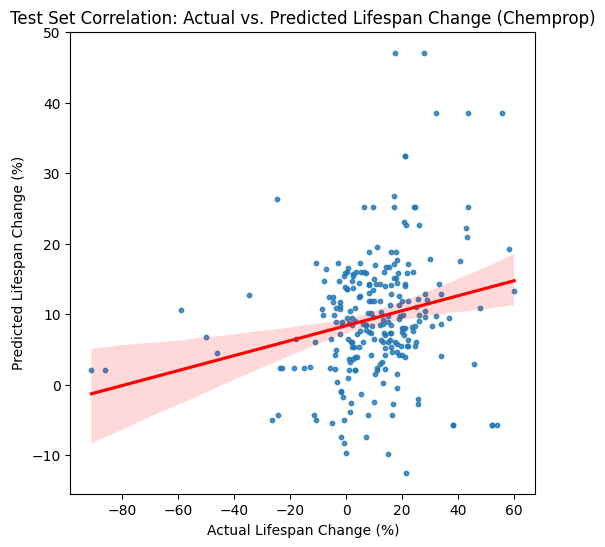

In [26]:
plt.figure(figsize=(6, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel("Actual Lifespan Change (%)")
plt.ylabel("Predicted Lifespan Change (%)")
plt.title("Test Set Correlation: Actual vs. Predicted Lifespan Change (Chemprop)")
plt.show()